# Exercise 4

Lisa Fenzel
Christian Teutsch 
Jan Straub

## 1 Constructing the matrix X

In [22]:
import numpy as np   
import matplotlib.pyplot as plt  
from scipy.sparse import coo_matrix, csc_matrix, linalg

The material for this sheet contains the list of angles and the measured sensor data for two versions of the experiment.

The smaller one was created with image size 77 x 77, sensor size 109 and 90 projection angles.
The larger one was created with image size 195 x 195, sensor size 275 and 179 projection angles.

The corresponding files are called 'y_77.npy', 'alphas_77.npy', 'y_195.npy' and 'alphas_195.npy'.

Unless you have a fairly powerful machine, we recommend starting with the smaller version of the data.

In [23]:
def construct_X(M, alphas, Np = None):
    # Check if Np is provided, otherwise calculate it based on M
    if Np is None:
        Np = int(np.sqrt(2) * M)

    D = M * M
    N = Np * len(alphas)

    # Convert angles to radians
    alphas_rad = np.deg2rad(alphas)

    # Create coordinate grid
    c = np.mgrid[-M / 2 + 0.5: M / 2, -M / 2 + 0.5: M / 2]
    c[0] = -c[0]

    # Reshape coordinate grid
    C1 = np.reshape(c, (2, D))
    C = np.zeros((len(alphas_rad), 2, D))
    C[:] = C1

    # Calculate sin and cos values for each angle
    n = np.array([np.sin(alphas_rad), np.cos(alphas_rad)])

    # Calculate s0 value
    s0 = np.sqrt(2) * (M / 2 - 0.5)

    # Calculate positions where the beam hits the sensor
    p = np.multiply(C[:, 0, :].T, n[0]).T + np.multiply(C[:, 1, :].T, n[1]).T + s0

    # Calculate step between sensor positions
    step = 2 * s0 / (Np - 1)

    detect = p / step

    # Calculate the detector indices for the lower and upper positions
    detect_indices_lower = np.floor(detect).astype(int)
    detect_indices_lower = np.clip(detect_indices_lower, 0, Np - 1)
    detect_indices_upper = detect_indices_lower + 1

    # Concatenate the lower and upper indices
    detect_indices = np.concatenate((detect_indices_lower, detect_indices_upper), axis = 1)

    # Adjust the indices based on the angle
    detect_indices += np.arange(0, Np * len(alphas), Np)[:, np.newaxis]

    # Calculate the weight for each pixel
    weight_2 = detect - detect_indices_lower
    weight_1 = 1 - weight_2

    # Flatten the weight arrays and concatenate them
    data = np.concatenate((weight_1, weight_2), axis = 1).flatten()

    # Get the non-zero indices for constructing the sparse matrix
    i_indices = detect_indices.flatten()[data != 0]
    j_indices = np.zeros((len(alphas_rad), 2, D))
    j_indices[:, :] = np.arange(D)
    j_indices = j_indices.flatten()[data != 0]

    # Filter out the non-zero weights
    data = data[data != 0]

    # Create the sparse matrix
    X = coo_matrix((data, (i_indices, j_indices)), shape=(N, D))

    return X

<div style="color: green; font-weight: bold">Different from Solution uses numpy functionality better</div>

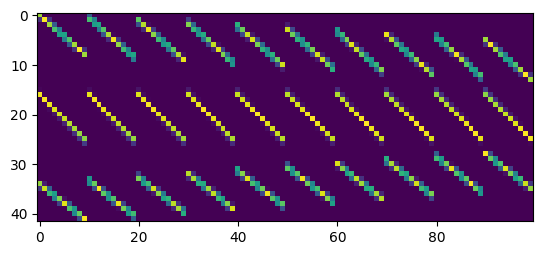

In [24]:
X_test1 = construct_X(10 ,np.array([-33, 1, 42]))
plt.imshow(X_test1.toarray())

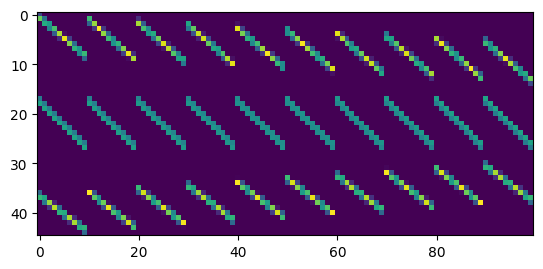

In [25]:
X_example = np.load('hs_tomography/X_example.npy')
plt.imshow(X_example)

## 2 Recovering the image

<div style="color: green; font-weight: bold">similar to solution uses different color theme</div>

In [26]:
alphas = np.load("hs_tomography/alphas_77.npy")
imageSize = 77
sensorSize = 109

X_test2 = construct_X(imageSize, alphas, sensorSize)

num_nonzero_entries = X_test2.nnz
print("Number of non zero entries:", num_nonzero_entries)


total_entries = X_test2.shape[0] * X_test2.shape[1]
sparsity = 1.0 - (num_nonzero_entries / total_entries)
print("Sparcity:", sparsity)


Number of non zero entries: 1066918
Sparcity: 0.9816565684074322


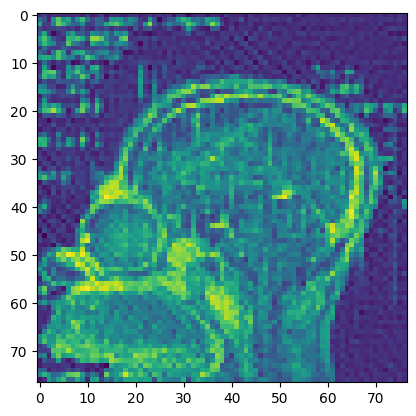

In [27]:
y = np.load("hs_tomography/y_77.npy")

beta = linalg.lsqr(X_test2, y, atol = 1e-03, btol = 1e-03) 
beta_matrix = np.reshape(beta[0], (imageSize, imageSize))
plt.imshow(beta_matrix)

In [28]:
alphas = np.load("hs_tomography/alphas_195.npy")
imageSize = 195
sensorSize = 275

X = construct_X(imageSize, alphas, sensorSize)

num_nonzero_entries = X.nnz
print("Number of non zero entries:", num_nonzero_entries)

total_entries = X.shape[0] * X.shape[1]
sparsity = 1.0 - (num_nonzero_entries / total_entries)
print("Sparcity:", sparsity)

Number of non zero entries: 13612027
Sparcity: 0.992727765840615


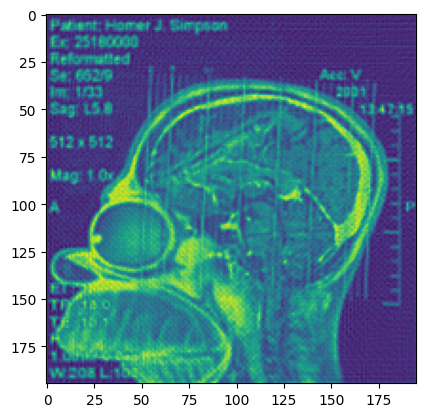

In [29]:
y = np.load("hs_tomography/y_195.npy")

beta_195 = linalg.lsqr(X, y, atol = 1e-03, btol = 1e-03)
beta_matrix_195 = np.reshape(beta_195[0], (imageSize, imageSize))
plt.imshow(beta_matrix_195)

## 3 Minimizing the radiation dose

First we reduced

In this task, we want to reduce the number of projection angles. First, we will try to achieve this by omitting very small and very large angles. We find that we only need angles between $$-60\degree $$ and $$+60 \degree$$ to identify the cause of the headaches. Therefore, we were able to save 30 angles on each side, resulting in a total reduction of 60 angles.

We reduced the number of projection angles by 60 


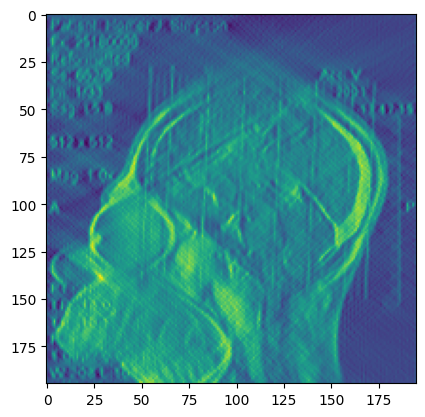

In [30]:
alphas = np.load("hs_tomography/alphas_195.npy")
y = np.load("hs_tomography/y_195.npy")

imageSize = 195
sensorSize = 275
reduction = 30

N = sensorSize * len(alphas)
reduced_alphas_1 = alphas[reduction:-reduction]
N_reduced = sensorSize * len(reduced_alphas_1)
y_reduction = int((N - N_reduced) / 2)
reduced_y_1 = y[y_reduction:-y_reduction]

print(f"We reduced the number of projection angles by {len(alphas) - len(reduced_alphas_1)} ")

X_1 = construct_X(imageSize, reduced_alphas_1, sensorSize)

beta = linalg.lsqr(X_1, reduced_y_1, atol = 1e-03, btol = 1e-03)
beta_matrix = np.reshape(beta[0], (imageSize, imageSize))
plt.imshow(beta_matrix)



Next, we will omit every third angle, allowing us to save nearly 60 projection angles as well.

We reduced the number of projection angles by: 59 


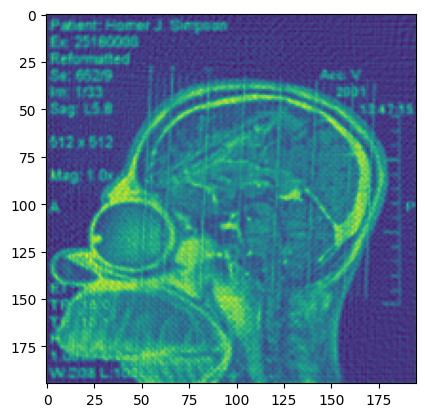

In [31]:
alphas = np.load("hs_tomography/alphas_195.npy")
y = np.load("hs_tomography/y_195.npy")

reduced_alphas_2 = []
for i in range(0, len(alphas),3 ):
    reduced_alphas_2.extend(alphas[i:i+2])


imageSize = 195
sensorSize = 275


reduced_y_2 = []
for i in range(0, len(alphas)):
    block_start = i * sensorSize*3
    block_end = (i + 1) *  sensorSize*3
    reduced_y_2.extend(y[block_start : block_end -sensorSize])



print(f"We reduced the number of projection angles by: {len(alphas) - len(reduced_alphas_2)} ")

X_2 = construct_X(imageSize, reduced_alphas_2, sensorSize)

beta = linalg.lsqr(X_2, reduced_y_2, atol = 1e-03, btol = 1e-03)
beta_matrix = np.reshape(beta[0], (imageSize, imageSize))
plt.imshow(beta_matrix)

By omitting every second angle, we  reduce the number of projection angles by 89.

We reduced the number of projection angles by: 89 


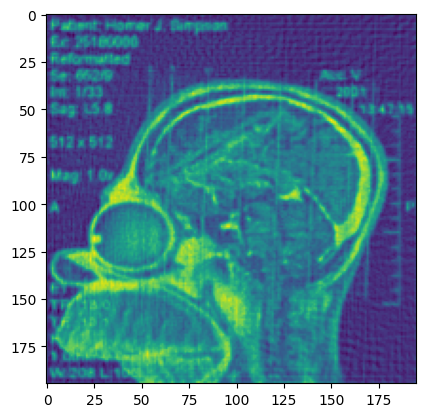

In [32]:
alphas = np.load("hs_tomography/alphas_195.npy")
y = np.load("hs_tomography/y_195.npy")

reduced_alphas_3 = []
for i in range(0, len(alphas),2 ):
    reduced_alphas_3.extend(alphas[i:i+1])


imageSize = 195
sensorSize = 275


reduced_y_3 = []
for i in range(0, len(alphas)):
    block_start = i * sensorSize*2
    block_end = (i + 1) *  sensorSize*2
    reduced_y_3.extend(y[block_start : block_end -sensorSize])



print(f"We reduced the number of projection angles by: {len(alphas) - len(reduced_alphas_3)} ")

X_test3 = construct_X(imageSize, reduced_alphas_3, sensorSize)

beta = linalg.lsqr(X_test3, reduced_y_3, atol = 1e-03, btol = 1e-03)
beta_matrix = np.reshape(beta[0], (imageSize, imageSize))
plt.imshow(beta_matrix)

Finally, we combine both methods. First, we omit 15 angles on each side, resulting in a reduction of 30 angles. Then, we further omit every second angle. So we can save a total of 104 projection angles.

We reduced the number of projection angles by 104 


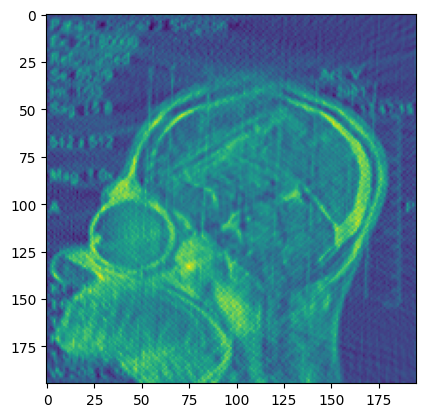

In [33]:
alphas = np.load("hs_tomography/alphas_195.npy")
y = np.load("hs_tomography/y_195.npy")

imageSize = 195
sensorSize = 275
reduction = 15

N = sensorSize * len(alphas)
reduced_alphas_3_1 = alphas[reduction:-reduction]
N_reduced = sensorSize * len(reduced_alphas_3_1)
y_reduction = int((N - N_reduced) / 2)
reduced_y_3_1 = y[y_reduction:-y_reduction]

reduced_alphas_3 = []
for i in range(0, len(reduced_alphas_3_1),2 ):
    reduced_alphas_3.extend(reduced_alphas_3_1[i:i+1])


imageSize = 195
sensorSize = 275


reduced_y_3 = []
for i in range(0, len(reduced_alphas_3_1)):
    block_start = i * sensorSize*2
    block_end = (i + 1) *  sensorSize*2
    reduced_y_3.extend(reduced_y_3_1[block_start : block_end -sensorSize])


print(f"We reduced the number of projection angles by {len(alphas) - len(reduced_alphas_3)} ")

X_3 = construct_X(imageSize, reduced_alphas_3, sensorSize)

beta = linalg.lsqr(X_3, reduced_y_3, atol = 1e-03, btol = 1e-03)
beta_matrix = np.reshape(beta[0], (imageSize, imageSize))
plt.imshow(beta_matrix)


We would say that the minimal number of projection angles is around 100. This, we would say, enables the 
doctor to still identify the abnormality in the brain of the patient.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8bc038ec-9337-4e83-b23f-51e2fbd0faf9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

<div style="color: green; font-weight: bold">Different from solution takes a logical approach to reduce angles that don't contribute much to the overall solution</div>